In [1]:
from qiskit import QuantumCircuit, Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.opflow import StateFn, Z, I
from qiskit.opflow import Gradient, CircuitSampler, PauliExpectation


from qiskit_machine_learning.datasets import iris
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier

import numpy as np
from time import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
random_state=123

In [3]:
X, Y = datasets.load_iris(return_X_y=True)

# Reduce problem to binary classification
is_class_2 = Y == 2
X = X[~is_class_2]
Y = Y[~is_class_2]
Y = Y * 2 - 1  # map form {0, 1} to Z expectation values of {-1,+1}

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=True, random_state=random_state
)

# Standardize data (i.e. mean of 0 with unit variance)
std_scale = StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

# Scale to between -1 and 1
X_std = np.append(x_train, x_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(X_std)
x_train = minmax_scale.transform(x_train)
x_test = minmax_scale.transform(x_test)

In [4]:
x_0 = x_train[0]
w_0 = np.random.rand(12)
y_0 = y_train[0]

In [5]:
sv_sim = Aer.get_backend('statevector_simulator') 
qasm_sim = Aer.get_backend('qasm_simulator') 

sv_quantum_instance = QuantumInstance(sv_sim, shots=1024, seed_simulator=random_state, seed_transpiler=random_state)
qasm_quantum_instance = QuantumInstance(qasm_sim, shots=10, seed_simulator=random_state, seed_transpiler=random_state)

In [27]:
n = 4  # number of qubits

feature_map = ZZFeatureMap(
    feature_dimension=n,
    reps=1,
    entanglement='circular',
)
# feature_map.decompose().draw('mpl')

ansatz = RealAmplitudes(
    num_qubits=n,
    reps=2,
    entanglement='full'
)
# ansatz.decompose().draw('mpl')

hamiltonian = Z ^ Z ^ Z ^ Z
qnn_circuit = feature_map.compose(ansatz)
# qnn_circuit = qnn_circuit.compose(qnn_circuit)
qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qnn_circuit)

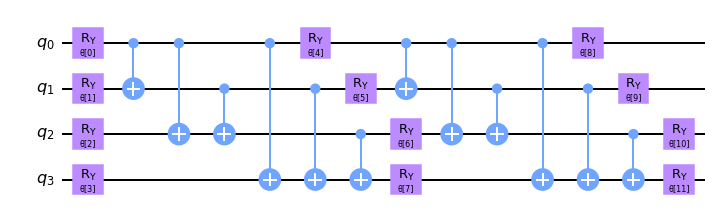

In [37]:
ansatz.decompose().draw('mpl')

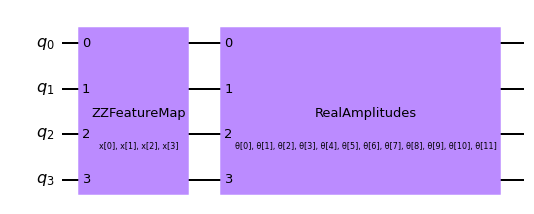

In [20]:
qnn_circuit.draw('mpl')

In [21]:
pauli_converter = PauliExpectation()

In [22]:
qnn = OpflowQNN(
    operator=qnn_expectation,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    exp_val=pauli_converter,
    gradient=Gradient(),
    quantum_instance=qasm_quantum_instance
)

In [23]:
weight_list = []
value_list = []
def model_callback(weights, values):
    weight_list.append(weights)
    value_list.append(values)
    print(f'-- Value: {values}')

model = NeuralNetworkClassifier(
    qnn,
    loss='squared_error',
    one_hot=False,
    optimizer=None,
    warm_start=False,
    initial_point=None,
#     callback=model_callback
)

In [24]:
ts = time()
model.fit(x_train, y_train)
print(f'Time to fit: {round(time()-ts, 3)}s')

Time to fit: 123.901s


In [36]:
s = model.score(x_test, y_test)
s

0.75